# How to predict Gold and Silver prices based on other trends
### The aim for this project, is to use historical data of minerals and indexes to try and see if it is possible to predict the daily price of gold and silver. Obviously this isn't meant to encourage people into 'trading' gold and silver, because they are long term ways to keep your money safer than in "cash", as Robert Kiyosaki says "Gold and Silver are God's money". 

### So the objective here is to learn how we can use PyTorch to test if we can predict silver and gold prices, based on a correlation between (if there is) gold/silver with us debt, inflation and fed printing money.

In [1]:
import torch
import numpy as np
from torch import nn
import math, time
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import missingno as msno
import seaborn as sns
import gc


In [2]:
# This data was obtained through https://www.investing.com/commodities/metals
silver = pd.read_csv('datasets/Finance/Silver Futures Historical Data.csv')
gold = pd.read_csv('datasets/Finance/Gold Futures Historical Data.csv')
copper = pd.read_csv('datasets/Finance/Copper Futures Historical Data.csv')
palladium = pd.read_csv('datasets/Finance/Palladium Futures Historical Data.csv')
platinum = pd.read_csv('datasets/Finance/Platinum Futures Historical Data.csv')

In [3]:
silver.tail()

,Date,Price,Open,High,Low,Vol.,Change %
2600,02/01/2013,31.988,31.615,32.095,31.605,0.01K,1.94%
2601,01/31/2013,31.380,31.470,31.845,31.190,0.00K,-2.66%
2602,01/30/2013,32.237,31.405,32.350,31.330,2.54K,3.38%
2603,01/29/2013,31.184,30.850,31.470,30.850,32.35K,1.31%
2604,01/28/2013,30.780,31.160,31.320,30.745,37.83K,-1.37%


In [4]:
len(silver), len(gold), len(copper), len(palladium), len(platinum)

(2605, 2619, 2612, 2878, 3137)

In [5]:
# Check Inflation Data
# https://www.kaggle.com/datasets/varpit94/us-inflation-data-updated-till-may-2021
inflation = pd.read_csv('datasets/Finance/us cpi/US CPI.csv')
inflation

,Yearmon,CPI
0,01-01-1913,9.800
1,01-02-1913,9.800
2,01-03-1913,9.800
3,01-04-1913,9.800
4,01-05-1913,9.700
...,...,...
1298,01-03-2021,264.877
1299,01-04-2021,267.054
1300,01-05-2021,269.195
1301,01-06-2021,271.696


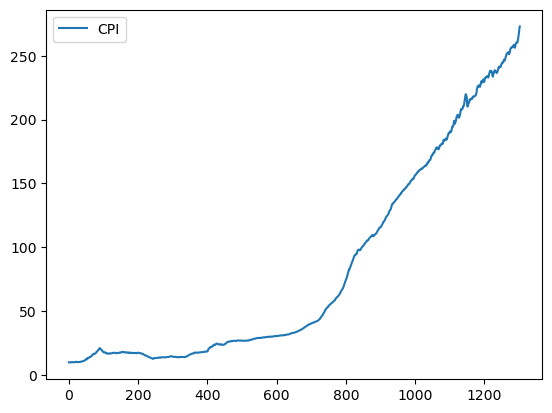

In [6]:
inflation.plot();

In [7]:
# https://www.kaggle.com/datasets/federalreserve/interest-rates
fedrates = pd.read_csv('datasets/Finance/federalreserverates/index.csv')
fedrates

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN
...,...,...,...,...,...,...,...,...,...,...
899,2016,12,14,NaN,0.75,0.50,NaN,NaN,NaN,NaN
900,2017,1,1,NaN,0.75,0.50,0.65,NaN,4.8,2.3
901,2017,2,1,NaN,0.75,0.50,0.66,NaN,4.7,2.2
902,2017,3,1,NaN,0.75,0.50,NaN,NaN,NaN,NaN


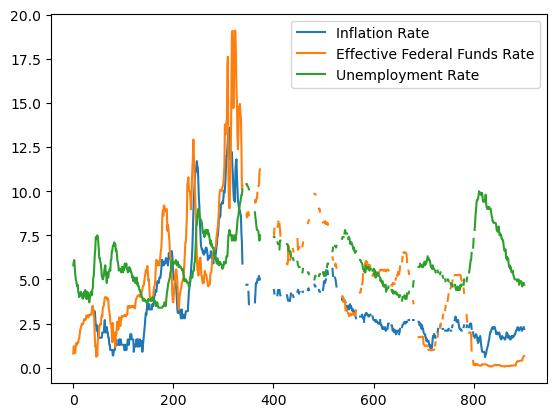

In [8]:
fedrates[['Inflation Rate', 'Effective Federal Funds Rate', 'Unemployment Rate']].plot();

### Missing Data

- Vol has too many missing values so I'm avoiding it.

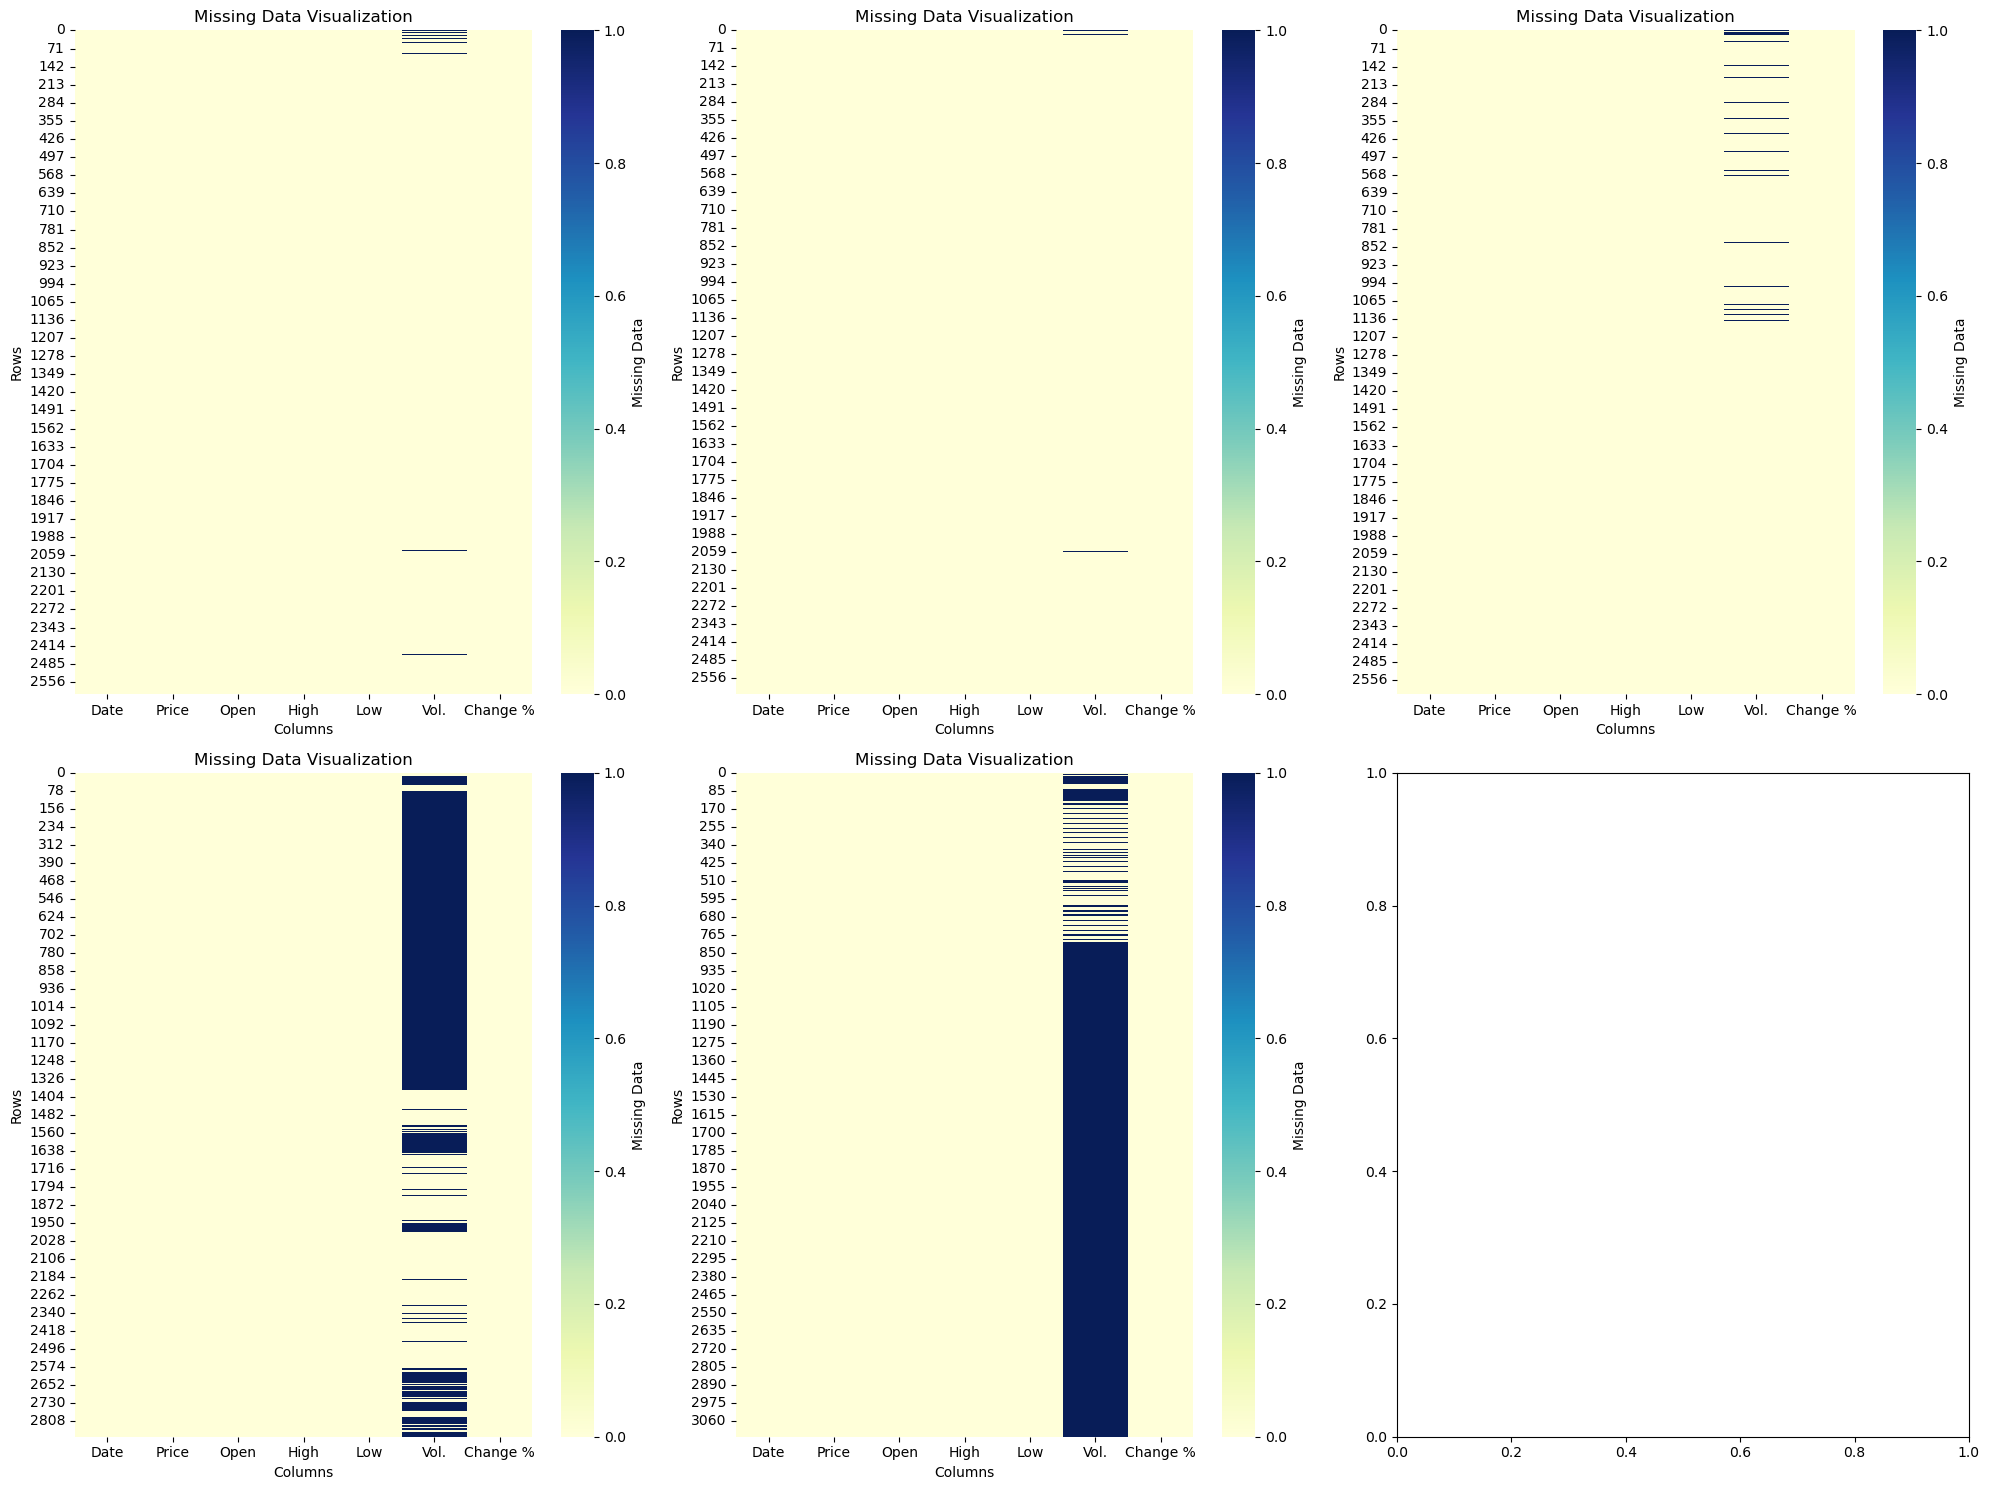

In [9]:
dfs_list = [silver, gold, copper, palladium, platinum]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))

for df, ax in zip(dfs_list, axes.flatten()):
    sns.heatmap(df.isna(),
                cmap="YlGnBu",
                cbar_kws={'label': 'Missing Data'},
                ax=ax)
    ax.set_title("Missing Data Visualization")
    ax.set_xlabel("Columns")
    ax.set_ylabel("Rows")

plt.tight_layout()
plt.show()

In [10]:
silver = silver.drop(columns='Vol.')
gold = gold.drop(columns='Vol.')
copper = copper.drop(columns='Vol.')
palladium = palladium.drop(columns='Vol.')
platinum = platinum.drop(columns='Vol.')
print('Removed Vol.')

Removed Vol.


### Addressing the data type problems
 * , for thousand units
 * %

In [11]:
def stringToNumber(data):
    df = data.copy()
    cols = df.columns
    for c in cols:
        if df[c].dtype == 'object':
            df[c] = df[c].str.replace('%', '')  # Remove percentage symbols
            df[c] = df[c].str.replace(',', '')  # Remove thousand separators
            df[c] = df[c].astype(float)  # Convert to float
    return df

silver[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(silver[['Price', 'Open', 'High', 'Low', 'Change %']])
gold[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(gold[['Price', 'Open', 'High', 'Low', 'Change %']])
copper[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(copper[['Price', 'Open', 'High', 'Low', 'Change %']])
palladium[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(palladium[['Price', 'Open', 'High', 'Low', 'Change %']])
platinum[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(platinum[['Price', 'Open', 'High', 'Low', 'Change %']])
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2619 entries, 0 to 2618
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2619 non-null   object 
 1   Price     2619 non-null   float64
 2   Open      2619 non-null   float64
 3   High      2619 non-null   float64
 4   Low       2619 non-null   float64
 5   Change %  2619 non-null   float64
dtypes: float64(5), object(1)
memory usage: 122.9+ KB


In [12]:
# Format date
silver['Date'] = pd.to_datetime(silver['Date'], format='%m/%d/%Y')
gold['Date'] = pd.to_datetime(gold['Date'], format='%m/%d/%Y')
copper['Date'] = pd.to_datetime(copper['Date'], format='%m/%d/%Y')
palladium['Date'] = pd.to_datetime(palladium['Date'], format='%m/%d/%Y')
platinum['Date'] = pd.to_datetime(platinum['Date'], format='%m/%d/%Y')

- If we take a look at the data, there is an inconsistency with the dates. Sometimes it has less sundays, sometimes more, it could be related to global changes in different times or market behaviour.
- There are no saturdays.

In [13]:
def countSundays(dfs):
    for index, d in enumerate(dfs):
        a = d.copy()
        a['Day'] = a['Date'].dt.day_name()
        print(index, a['Day'].value_counts()['Sunday'])
countSundays([silver, gold, copper, palladium, platinum])

0 15
1 3
2 21
3 247
4 517


In [27]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

print(silver.shape[0])
date_range = pd.date_range(
    platinum['Date'].min(), 
    platinum['Date'].max(), freq='B')
date_df = pd.DataFrame({'Date': date_range})
print(date_df.shape[0])

print(silver[~silver['Date'].isin(date_df['Date'])].shape)
print(gold[~gold['Date'].isin(date_df['Date'])].shape)
print(copper[~copper['Date'].isin(date_df['Date'])].shape)
print(palladium[~palladium['Date'].isin(date_df['Date'])].shape)
print(platinum[~platinum['Date'].isin(date_df['Date'])].shape)

print(date_df[~date_df['Date'].isin(silver['Date'])].shape)
print(date_df[~date_df['Date'].isin(gold['Date'])].shape)
print(date_df[~date_df['Date'].isin(copper['Date'])].shape)
print(date_df[~date_df['Date'].isin(palladium['Date'])].shape)
print(date_df[~date_df['Date'].isin(platinum['Date'])].shape)

print(platinum[~platinum['Date'].isin(date_df['Date'])].sample(10))


2605
2632
(15, 6)
(13, 6)
(31, 6)
(257, 6)
(517, 6)
(42, 1)
(26, 1)
(51, 1)
(11, 1)
(12, 1)
           Date    Price     Open     High      Low  Change %
614  2021-03-07  1142.45  1131.30  1142.55  1129.00      0.84
835  2020-06-21   826.75   834.85   834.85   826.10      0.26
632  2021-02-14  1271.45  1264.25  1272.20  1264.00      0.79
3006 2013-06-30  1347.00  1340.35  1350.75  1336.05      0.27
3095 2013-03-17  1589.80  1583.45  1597.30  1583.45     -0.07
2344 2015-08-16   993.45   991.90   994.65   991.20      0.07
126  2022-10-02   861.00   862.00   862.95   859.45      0.01
2125 2016-05-01  1079.75  1078.90  1081.15  1076.35     -0.02
168  2022-08-14   960.60   964.80   965.25   960.50     -0.03
1708 2017-09-03  1016.75  1012.35  1018.00  1012.35      0.54


In [15]:
date_range = pd.date_range(
    min(silver['Date'].min(), silver['Date'].min()), 
    max(silver['Date'].max(), silver['Date'].max()), freq='D')

date_df = pd.DataFrame({'Date': date_range})

print(
    min(silver['Date'].min(), silver['Date'].min()), 
    max(silver['Date'].max(), silver['Date'].max())
)
merged_df_silver = pd.merge(date_df, silver, how='left', on='Date')
merged_df_gold = pd.merge(date_df, gold, how='left', on='Date')
merged_df_copper = pd.merge(date_df, copper, how='left', on='Date')
merged_df_palladium = pd.merge(date_df, palladium, how='left', on='Date')
merged_df_platinum = pd.merge(date_df, platinum, how='left', on='Date')

missing_dates_silver = merged_df_silver[merged_df_silver['Price'].isnull()]
missing_dates_gold = merged_df_gold[merged_df_gold['Price'].isnull()]
missing_dates_copper = merged_df_copper[merged_df_copper['Price'].isnull()]
missing_dates_palladium = merged_df_palladium[merged_df_palladium['Price'].isnull()]
missing_dates_platinum = merged_df_platinum[merged_df_platinum['Price'].isnull()]

print("Missing values of silver")
print(len(missing_dates_silver))
print("Missing values of gold")
print(len(missing_dates_gold))
print("Missing values of copper")
print(len(missing_dates_copper))
print("Missing values of palladium")
print(len(missing_dates_palladium))
print("Missing values of platinum")
print(len(missing_dates_platinum))

2013-01-28 00:00:00 2023-02-28 00:00:00
Missing values of silver
1079
Missing values of gold
1075
Missing values of copper
1082
Missing values of palladium
816
Missing values of platinum
547


In [16]:
asdf

NameError: name 'asdf' is not defined

<AxesSubplot: title={'center': 'Silver Price with missing days'}>

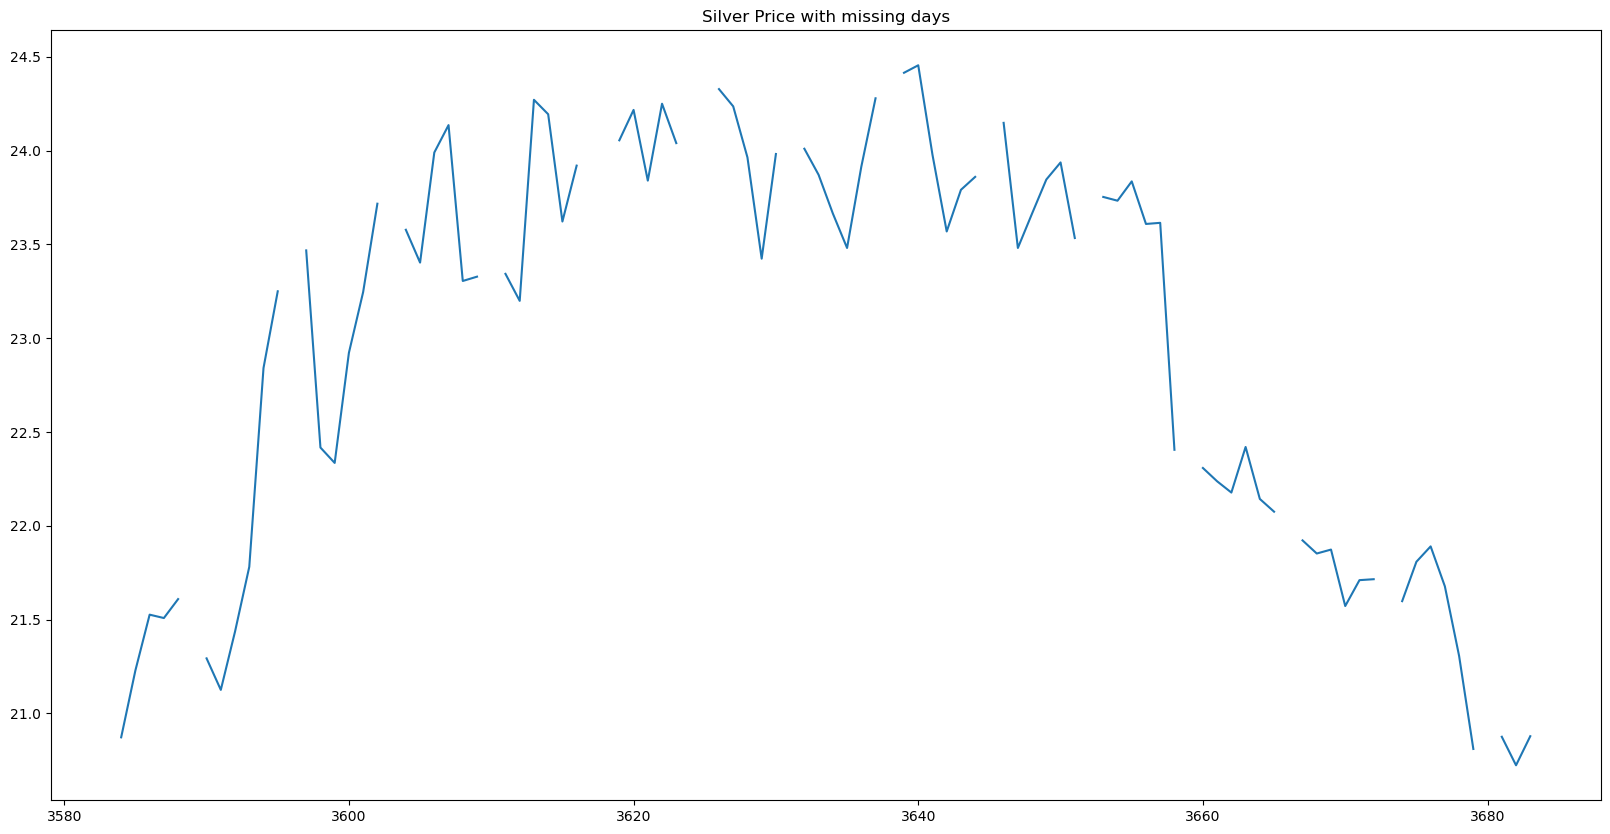

In [ ]:
# Now we can see that the missing data is way more that we expected
# The model I want to make is designed to work by a daily base, so it's easier to keep track and fix
# So we need to fill the gaps
# But this can be fixed by using data imputation techniques
merged_df_silver["Price"][-100:].plot(title="Silver Price with missing days", figsize=(20,10))

* But what are these missing values? They seem to be continuous, and probably is because markets close on Saturday.
* And also, even though data was obtained in the same time range, there are different quantities of missing data, so probably there is even more reasons to that, so we can't be 100% sure.
* So the best would be trying to complete the missing parts based on the previous and future values.

In [ ]:
gc.collect()

# Data imputation

Source: https://github.com/Idilismiguzel/data_analysis/blob/main/missing_data/Missing_Value_Imputation.ipynb

### Fillna is a method which can fill the missing data points
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html

There are different type of fill types
* bfill: use next valid observation to fill gap
* ffill: propagate last valid observation forward to next valid backfill

<AxesSubplot: title={'center': 'Silver Price with missing days'}>

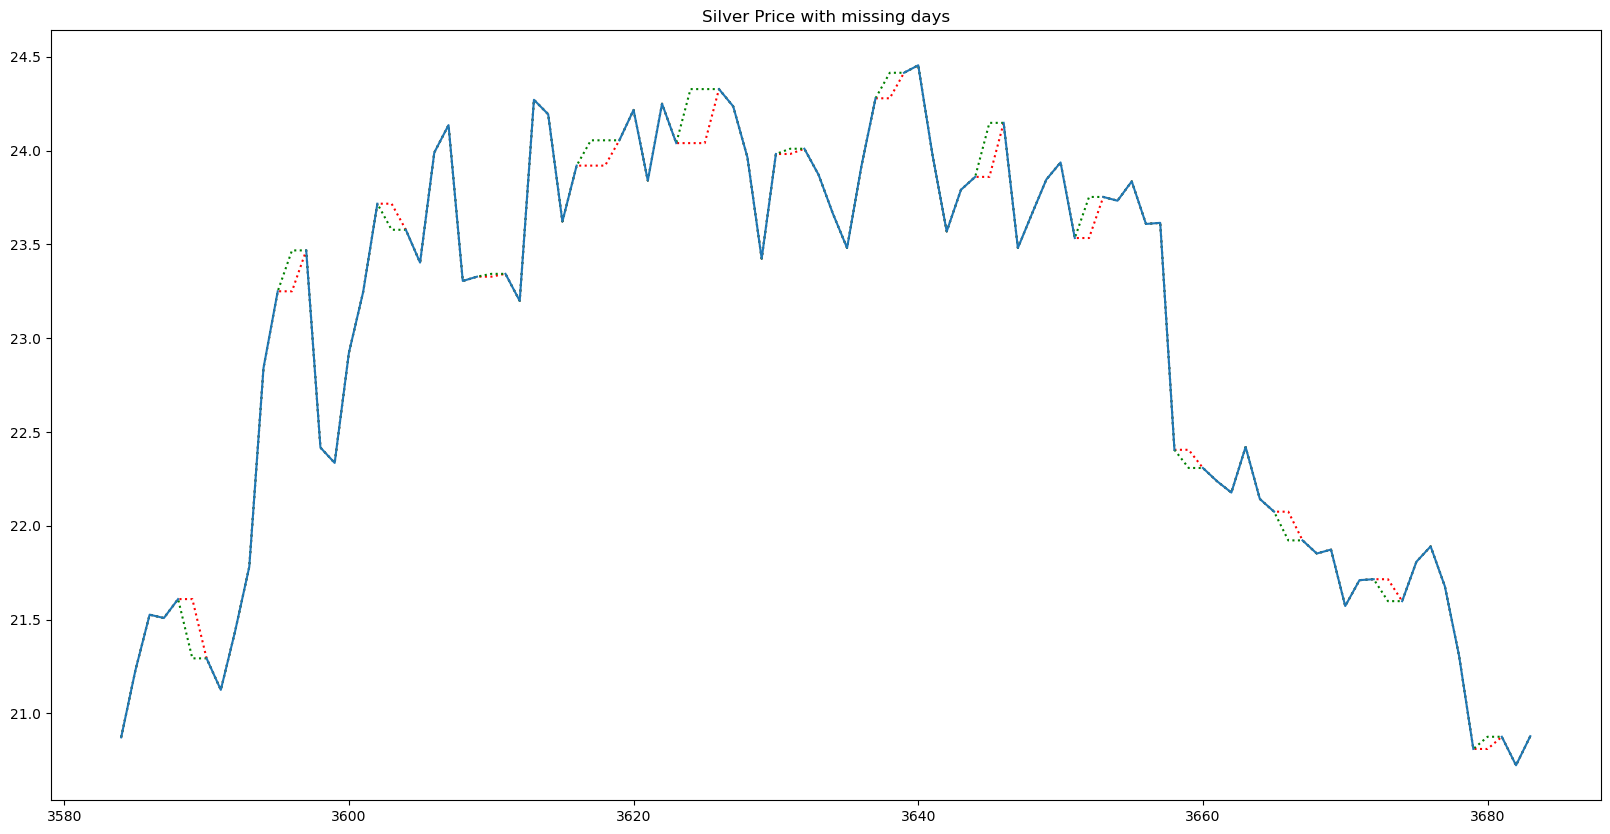

In [ ]:
merged_df_silver_imp = merged_df_silver["Price"].fillna(method="ffill")
merged_df_silver_imp_2 = merged_df_silver["Price"].fillna(method="bfill")

merged_df_silver_imp[-100:].plot(color="red", linestyle="dotted", figsize=(20,10))
merged_df_silver_imp_2[-100:].plot(color="green", linestyle="dotted", figsize=(20,10))
merged_df_silver["Price"][-100:].plot(title="Silver Price with missing days", figsize=(20,10))

<AxesSubplot: title={'center': 'Silver Price with missing days'}>

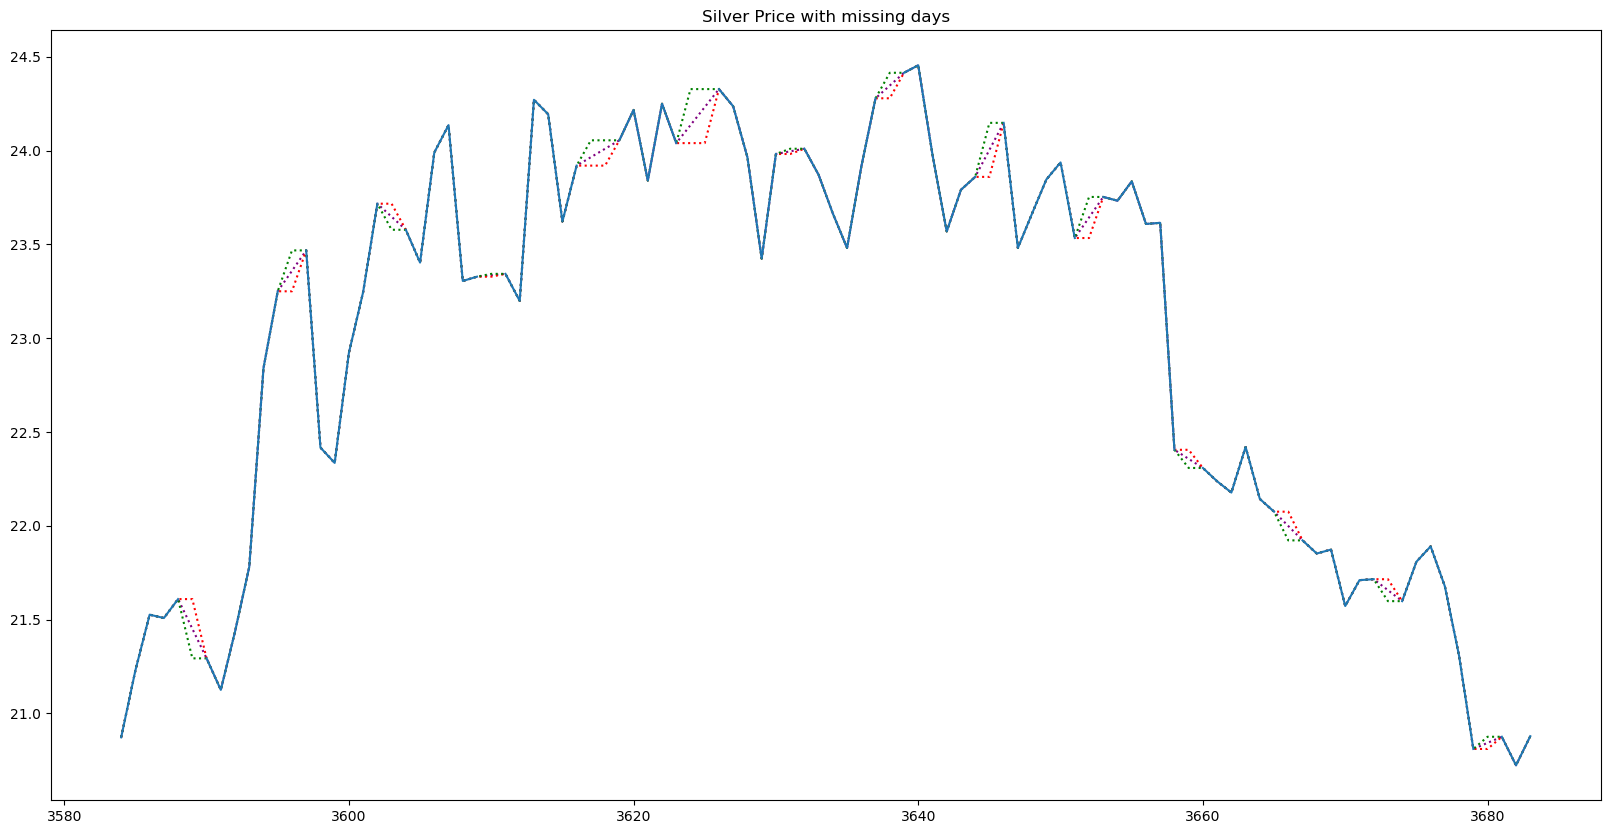

In [ ]:
# The problem with this is that in this scenario, one is too optimistic and the other is too pessimistic
# So I would prefer a middle ground
merged_df_silver_linear = merged_df_silver["Price"].interpolate(method="linear")

merged_df_silver_linear[-100:].plot(color="purple", linestyle="dotted", figsize=(20,10))
merged_df_silver_imp[-100:].plot(color="red", linestyle="dotted", figsize=(20,10))
merged_df_silver_imp_2[-100:].plot(color="green", linestyle="dotted", figsize=(20,10))
merged_df_silver["Price"][-100:].plot(title="Silver Price with missing days", figsize=(20,10))

3584    20.8720
3585    21.2290
3586    21.5260
3587    21.5080
3588    21.6090
         ...   
3679    20.8100
3680    20.8425
3681    20.8750
3682    20.7230
3683    20.8780
Name: Price, Length: 100, dtype: float64


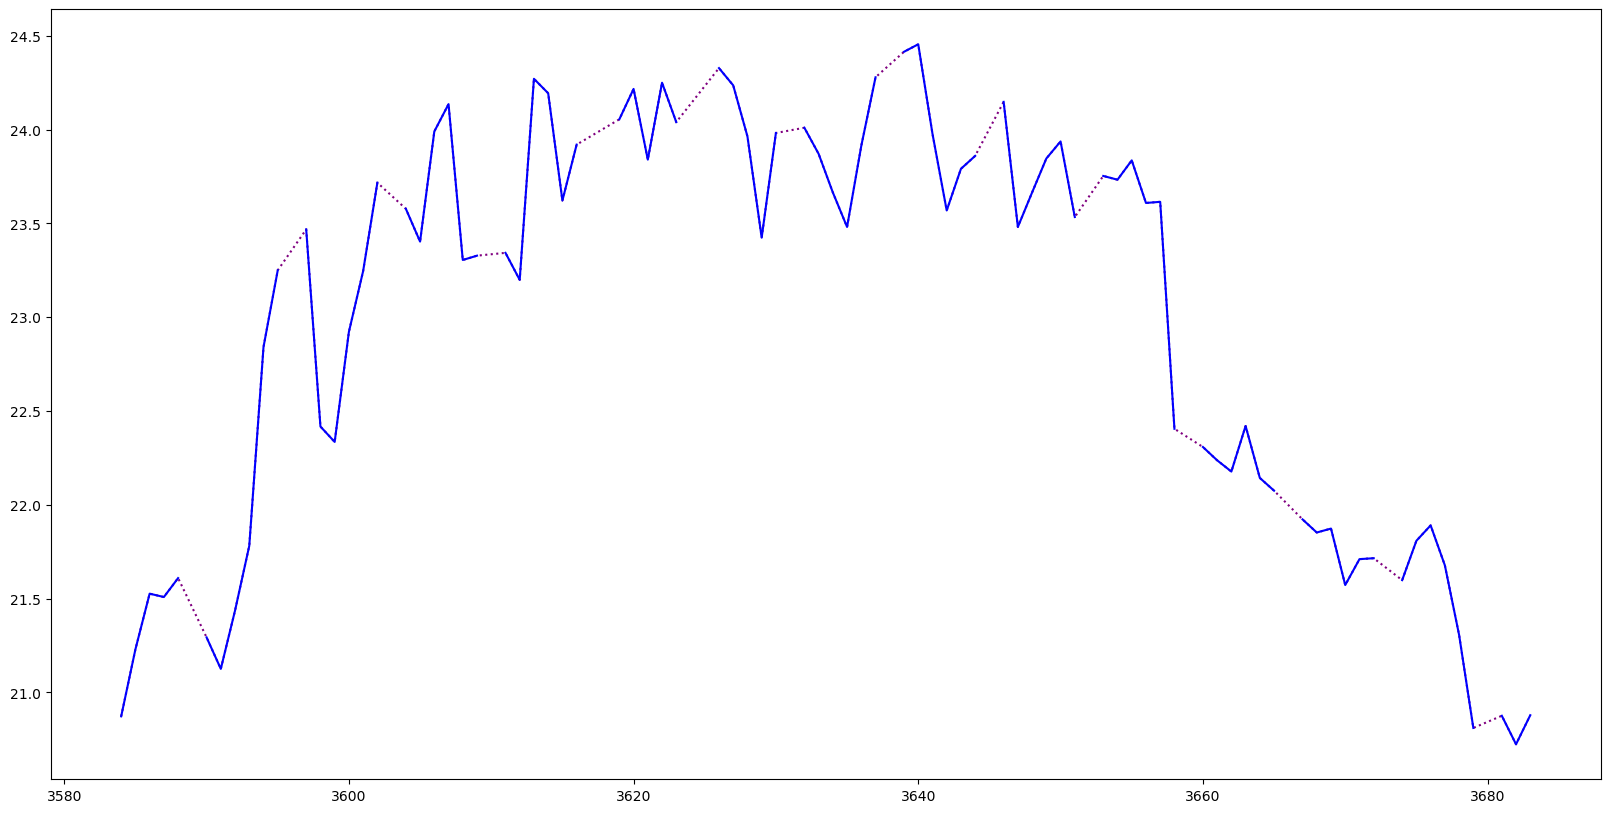

In [ ]:
# New dataset (tomato) vs Old (blue)
merged_df_silver_linear[-100:].plot(color="purple", linestyle="dotted", figsize=(20,10))
merged_df_silver["Price"][-100:].plot(figsize=(20,10), color="blue")
print(merged_df_silver_linear[-100:])

3664    22.1430
3665    22.0750
3666    21.9985
3667    21.9220
3668    21.8520
3669    21.8730
3670    21.5720
3671    21.7100
3672    21.7150
3673    21.6565
3674    21.5980
3675    21.8080
3676    21.8900
3677    21.6770
3678    21.3060
3679    20.8100
3680    20.8425
3681    20.8750
3682    20.7230
3683    20.8780
Name: Price, dtype: float64


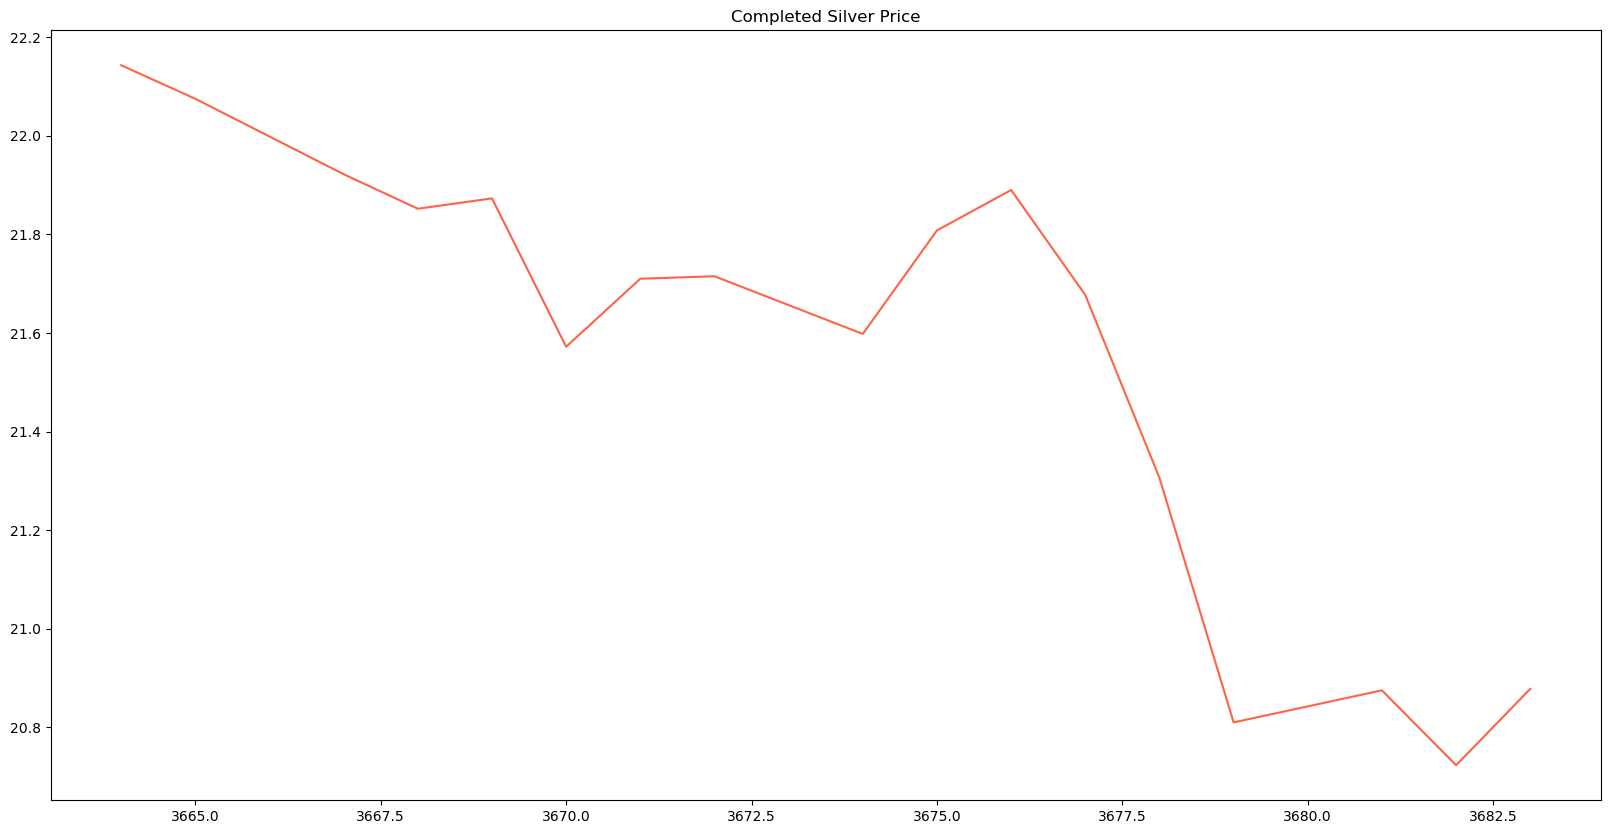

In [ ]:
# So, 14 missing values got completed like this, 
# which is a problem, and seems some values are missing, and all of that in this single graph
merged_df_silver_linear[-20:].plot(title="Completed Silver Price", figsize=(20,10), color="tomato")
print(merged_df_silver_linear[-20:])

In [ ]:
# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform()

TypeError: wrapped() missing 1 required positional argument: 'X'

# Shaping Data

* **Time series problem**: how to predict something based on time order. We cannot just simply make a range of 0 to n, indexing every data point, because, when we train the model, we'll use the time to train the model and to predict we will use the price data. If the data is just a simple 0 to n, it will just mean that our training data is a straight line. So we have to make a function that actually relates both the date and the data. In short we want a model that we input a future date, and we output the predicted price for that specific date, or prices for a set of dates.


In [ ]:
# https://www.crosstab.io/articles/time-series-pytorch-lstm/
class SilverDataset(Dataset):
    def __init__(self, data, target):
        self.X = torch.tensor(data).float()
        self.y = torch.tensor(target).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx,:,:], self.y[idx,:]

In [ ]:
#https://github.com/RodolfoLSS/stock-prediction-pytorch/blob/master/stock-prediction-pytorch.ipynb
#https://machinelearningmastery.com/training-a-pytorch-model-with-dataloader-and-dataset/

# This method takes the n-1 values from data to make X with n = lookback, and the value number n to make the target y
# So that basically uses [0, n-1] values with the target value at pos [n]
def split_data(data_raw, lookback, split):
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback + 1): # I Modified this part to generate the last piece of data missing
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round((1-split)*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [ ]:
def batch_data(data_raw, lookback):
    data = []
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback + 1): # I Modified this part to generate the last piece of data missing
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    
    x_ = data[:,:-1,:]
    y_ = data[:,-1,:]
    
    return [x_,y_]

In [ ]:
seq_length=30 # Sequence of data of previous X to train per each target value y
split=0.8

In [ ]:
x_silver_data, y_silver_data = batch_data(scaled_data, seq_length)
x_silver_train, y_silver_train, x_silver_test, y_silver_test = split_data(scaled_data, seq_length, split)
print('x_train.shape = ',x_silver_train.shape)
print('y_train.shape = ',y_silver_train.shape)
print('x_test.shape = ',x_silver_test.shape)
print('y_test.shape = ',y_silver_test.shape)
print('X_full.shape = ', x_silver_data.shape)
print('y_full.shape = ', y_silver_data.shape)


In [ ]:
dataset = SilverDataset(x_silver_data, y_silver_data)
len(dataset)

In [ ]:
train_len = int(len(dataset)*split)
lens = [train_len, len(dataset)-train_len]
train_ds, test_ds = random_split(dataset, lens)
trainloader = DataLoader(train_ds, batch_size=seq_length, shuffle=True, drop_last=True)
testloader = DataLoader(test_ds, batch_size=seq_length, shuffle=True, drop_last=True)

In [ ]:
merged_df_silver_linear

- The test data has the last 20% of the data, and the y array has the target values.
- Here we can see the comparison with the original data and the last values of y
- The difference is we filled with values for the 25 of feb ->  [20.8425]

In [ ]:
silver.head()

In [ ]:
print(scaler.inverse_transform(y_silver_test[-10:][::-1]))

# GRU (gated recurrent unit) & LSTM (long short term memory)
- GRUs or LSTMs (long short term memory) have been used to solve time series problems.
- GRU: 

https://pytorch.org/docs/stable/generated/torch.nn.GRU.html?highlight=gru#torch.nn.GRU

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM

https://arxiv.org/pdf/1412.3555.pdf
- LSTM: 

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [ ]:
x_silver_train = torch.from_numpy(x_silver_train).type(torch.Tensor)
x_silver_test = torch.from_numpy(x_silver_test).type(torch.Tensor)

y_silver_train_lstm = torch.from_numpy(y_silver_train).type(torch.Tensor)
y_silver_test_lstm = torch.from_numpy(y_silver_test).type(torch.Tensor)

y_silver_train_gru = torch.from_numpy(y_silver_train).type(torch.Tensor)
y_silver_test_gru = torch.from_numpy(y_silver_test).type(torch.Tensor)

### FULL
x_silver_data = torch.from_numpy(x_silver_data).type(torch.Tensor)
y_silver_data = torch.from_numpy(y_silver_data).type(torch.Tensor)

In [ ]:
#Setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define hyperparameters
input_size = 1
num_layers= 2
hidden_size = 16
output_size = 1
num_epochs = 100 # The model learns fast enough
learning_rate = 0.001

print(device)

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob=0.2):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout_prob)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
silver_model_gru = GRU(input_size, hidden_size, num_layers, output_size)
silver_model_gru

In [ ]:
silver_model_lstm = LSTM(input_size, hidden_size, num_layers, output_size)
silver_model_lstm

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean').to(device)
optimizer_gru = torch.optim.Adam(silver_model_gru.parameters(), 
                             lr=learning_rate)
optimizer_lstm = torch.optim.Adam(silver_model_lstm.parameters(), 
                             lr=learning_rate)

In [ ]:
# Training LSTM
hist = np.zeros(num_epochs)
hist_test = np.zeros(num_epochs)

start_time = time.time()

silver_model_lstm.to(device)

for epoch in range(num_epochs):
    #Train
    silver_model_lstm.train()
    
    # TRAINDATA
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        
        # Forward pass
        y_train_pred_lstm = silver_model_lstm(x)

        # Calculate the loss
        loss = loss_fn(y_train_pred_lstm, y)
        hist[epoch] = loss.item()

        # Optimizer zero grad
        optimizer_lstm.zero_grad()

        # Loss backward
        loss.backward()

        # Step the optimizer
        optimizer_lstm.step()
    
    # Test
    silver_model_lstm.eval()

    # TESTDATA
    for x, y in testloader:
        with torch.inference_mode():
            x = x.to(device)
            y = y.to(device)
            y_test_pred_lstm = silver_model_lstm(x)
            test_loss = loss_fn(y_test_pred_lstm, y)
            hist_test[epoch] = test_loss.item()

    if epoch % 10 == 0:
        print("Epoch ", epoch, 
              f"MSE: {loss.item():.5f}", 
              f"Test MSE: {test_loss.item():.5}")
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

In [ ]:
# Inference with ALL DATA
silver_model_lstm.eval()
with torch.no_grad():
    y_preds_lstm = silver_model_lstm(x_silver_data.to(device))

In [ ]:
# Rescale data into prices
lstm_silver_preds = pd.DataFrame(scaler.inverse_transform(y_preds_lstm.cpu().detach().numpy()))
original_data = pd.DataFrame(scaler.inverse_transform(y_silver_data.numpy()))

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original_data.index, y = original_data[0], label="Data", color='royalblue')
ax = sns.lineplot(x = lstm_silver_preds.index, y = lstm_silver_preds[0], label="Data", color='tomato')

ax.set_title('LSTM Silver price Train', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist[:], label="Train Loss", color='royalblue')
ax = sns.lineplot(data=hist_test[:], label="Test Loss", color='green')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Test Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
hist_gru = np.zeros(num_epochs)
hist_gru_test = np.zeros(num_epochs)

start_time = time.time()

silver_model_gru.to(device)

for epoch in range(num_epochs):
    #Train
    silver_model_gru.train()
    
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        
        # Forward pass
        y_train_pred_gru = silver_model_gru(x)

        # Calculate the loss
        loss = loss_fn(y_train_pred_gru, y)
        hist_gru[epoch] = loss.item()

        # Optimizer zero grad
        optimizer_gru.zero_grad()

        # Loss backward
        loss.backward()

        # Step the optimizer
        optimizer_gru.step()
    
    # Test
    silver_model_gru.eval()

    for x, y in testloader:
        with torch.inference_mode():
            x = x.to(device)
            y = y.to(device)
            y_test_pred_gru = silver_model_gru(x)
            test_loss = loss_fn(y_test_pred_gru, y)
            hist_gru_test[epoch] = test_loss.item()

    if epoch % 10 == 0:
        print("Epoch ", epoch, 
              f"MSE: {loss.item():.5f}", 
              f"Test MSE: {test_loss.item():.5}")
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

In [ ]:
# Inference
silver_model_gru.eval()
with torch.no_grad():
    y_preds_gru = silver_model_gru(x_silver_data.to(device))
with torch.no_grad():
    y_preds_gru_train = silver_model_gru(x_silver_train.to(device))
with torch.no_grad():
    y_preds_gru_test = silver_model_gru(x_silver_test.to(device))

In [ ]:
# Rescale data into prices
gru_silver_preds = pd.DataFrame(scaler.inverse_transform(y_preds_gru.cpu().detach().numpy()))
original_data = pd.DataFrame(scaler.inverse_transform(y_silver_data.numpy()))

gru_silver_preds_train = pd.DataFrame(scaler.inverse_transform(y_preds_gru_train.cpu().detach().numpy()))
original_data_train = pd.DataFrame(scaler.inverse_transform(y_silver_train_gru.numpy()))

gru_silver_preds_test = pd.DataFrame(scaler.inverse_transform(y_preds_gru_test.cpu().detach().numpy()))
original_data_test = pd.DataFrame(scaler.inverse_transform(y_silver_test_gru.numpy()))

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original_data.index, y = original_data[0], label="Data", color='royalblue')
ax = sns.lineplot(x = gru_silver_preds.index, y = gru_silver_preds[0], label="Data", color='tomato')

ax.set_title('GRU Silver price Full', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist_gru[:], label="Loss", color='royalblue')
ax = sns.lineplot(data=hist_gru_test[:], label="Test Loss", color='green')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Test Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original_data_train.index, y = original_data_train[0], label="Data", color='royalblue')
ax = sns.lineplot(x = gru_silver_preds_train.index, y = gru_silver_preds_train[0], label="Data", color='tomato')
ax.set_title('GRU Silver price Train', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1, 2, 2)
ax = sns.lineplot(x = original_data_test.index, y = original_data_test[0], label="Data", color='royalblue')
ax = sns.lineplot(x = gru_silver_preds_test.index, y = gru_silver_preds_test[0], label="Data", color='tomato')
ax.set_title('GRU Silver price Test', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
fig.set_figheight(6)
fig.set_figwidth(16)

* So now we've proven the models are learning from the data, but we need to evaluate if the model can predict unseen data.

In [ ]:
x_test = x_silver_data
days=0

In [ ]:
# Evaluate prediction
print(scaler.inverse_transform(x_test[-1]))
# 1 Day in the future
days+=1
# Prediction based on the last 30 days
silver_model_lstm.eval()
with torch.no_grad():
  y_preds = silver_model_gru(x_test[-1:].to(device))

# Put the predicted value on top and delete the last
future = torch.cat((x_test[-1:], y_preds[-1:].unsqueeze(dim=1).cpu()), 1)
future = future[:,1:,:]
x_test = torch.cat((x_test, future), 0)

print(f"Day {days} Predicted Value: ", scaler.inverse_transform(y_preds[-1:].cpu().detach().numpy()))

- How to make future predictions. The plan is to predict y using the las X values from Feb 28 of 2023
- and then add the prediction on the 30 values array where I would put it as if it were the

In [ ]:
# This will take the d-1 last days an produce the prediction for the dth day
# We will remove the last value of the d-1 days, and concatenate on top the dth predicted day
# And we will predict the next based on the new prediction
def futurePredictions(x_raw_data, n_preds, model):
    start_time = time.time()
    predictions = []
    x_data = x_raw_data[:]
    
    model.eval()
    for i in range(n_preds):
        with torch.no_grad():
            y_preds = model(x_data)
        predictions.append(y_preds.item())
        x_data = torch.cat(
            (x_data[:,1:,:], # Removes oldest day from the last batch (1, d-1, 1)
             y_preds[-1:].unsqueeze(dim=1)), 1) # Inserts prediction unsqueezed (1, 1) -> (1, 1, 1)        
    training_time = time.time()-start_time
    print("Time: {}".format(training_time))
    return predictions

# Instead of using just the last batch of days, it uses a set of batches of dates
def futurePredictionsBatch(x_raw_data, n_preds, model):
    start_time = time.time()
    predictions = []
    x_data = x_raw_data[:]
    
    model.eval()
    for i in range(n_preds):
        with torch.no_grad():
            y_preds = model(x_data)
        predictions.append(y_preds[-1:].item())
        x_data = torch.cat(
            (x_data[-1:,1:,:], # Removes oldest day from the last batch from the set of batches (1, d-1, 1)
             y_preds[-1:].unsqueeze(dim=1)), 1) # Inserts prediction unsqueezed (1, 1) -> (1, 1, 1)        
    training_time = time.time()-start_time
    print("Time: {}".format(training_time))
    return predictions

In [ ]:
days_in_the_future = 30 # Window of days
window_last_data = 500 # For plotting

In [ ]:
lstm_preds = futurePredictions(x_silver_data[-1:].to(device), days_in_the_future, silver_model_lstm)
lstm_preds_train_data = futurePredictionsBatch(x_silver_data.to(device), days_in_the_future, silver_model_lstm)

In [ ]:
last_data = x_silver_data[-1:]
last_data.device, last_data.shape

In [ ]:
with torch.no_grad():
    y_preds = silver_model_lstm(last_data.to(device))
y_preds = y_preds.cpu()
x_data = torch.cat(
    (last_data[:,1:,:],
    y_preds[-1:].unsqueeze(dim=1)), 
    1)
last_data = x_data
y_preds
#scaler.inverse_transform(x_data[0])
#scaler.inverse_transform(x_data.cpu())

In [ ]:
results_lstm = torch.tensor(np.array(lstm_preds)).float().unsqueeze(dim=1)
results_lstm_test = torch.tensor(np.array(lstm_preds_train_data)).float().unsqueeze(dim=1)

In [ ]:
scaler.inverse_transform(y_preds.cpu())

In [ ]:
gru_preds = futurePredictions(x_silver_data[-days_in_the_future:-(days_in_the_future-1)].to(device), days_in_the_future, silver_model_gru)
gru_preds_train_data = futurePredictionsBatch(x_silver_train.to(device), x_silver_test.shape[0], silver_model_gru)

In [ ]:
results_gru = torch.tensor(np.array(gru_preds)).float().unsqueeze(dim=1)
results_gru_test = torch.tensor(np.array(gru_preds_train_data)).float().unsqueeze(dim=1)

In [ ]:
target_preds = results_gru

past_data = pd.DataFrame(scaler.inverse_transform(y_silver_data.detach().numpy()))
predicted_data = pd.DataFrame(scaler.inverse_transform(target_preds))

fulld = np.concatenate((y_silver_data[:-days_in_the_future], target_preds))
full_data = pd.DataFrame(scaler.inverse_transform(fulld[-window_last_data:])) # Use last 1000 values
original = pd.DataFrame(scaler.inverse_transform(y_silver_data[-window_last_data:]))
test_preds_gru = pd.DataFrame(scaler.inverse_transform(results_gru_test))

In [ ]:
# The blue line separates the real data from the predicted data
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = full_data.index, y = full_data[0], label="Full", color='tomato')
ax.set_title('GRU Silver price Forecast', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10);
ax.axvline(x=window_last_data - days_in_the_future, color='royalblue', linestyle='--')

plt.subplot(1, 2, 2)
ax = sns.lineplot(x = predicted_data.index, y = predicted_data[0], label="Future", color='tomato')
ax.set_title('GRU Silver price prediction', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10);

fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
# Here we can see an example of the prediction of the last n days if we started predicting 1 month before the training data
# If we input the data from 30 days before 28 of feb 2023, we see in the orange line it kinda follows the trend.
# But what about unseen data?

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Original", color='royalblue')
ax = sns.lineplot(x = full_data.index, y = full_data[0], label="Predicted", color='tomato')

ax.set_title('GRU Silver price Forecast', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10);

fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
target_preds = results_lstm

past_data = pd.DataFrame(scaler.inverse_transform(y_silver_data.detach().numpy()))
predicted_data = pd.DataFrame(scaler.inverse_transform(target_preds))

fulld = np.concatenate((y_silver_data[:-days_in_the_future], target_preds))
full_data = pd.DataFrame(scaler.inverse_transform(fulld[-window_last_data:])) # Use last 1000 values
original = pd.DataFrame(scaler.inverse_transform(y_silver_data[-window_last_data:]))
test_preds_lstm = pd.DataFrame(scaler.inverse_transform(results_lstm_test))

In [ ]:
# The blue line separates the real data from the predicted data
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = full_data.index, y = full_data[0], label="Full", color='tomato')
ax.set_title('LSTM Silver price Forecast', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10);
ax.axvline(x=window_last_data - days_in_the_future, color='royalblue', linestyle='--')

plt.subplot(1, 2, 2)
ax = sns.lineplot(x = predicted_data.index, y = predicted_data[0], label="Future", color='tomato')
ax.set_title('LSTM Silver price prediction', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10);

fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Original", color='royalblue')
ax = sns.lineplot(x = full_data.index, y = full_data[0], label="Predicted", color='tomato')

ax.set_title('GRU Silver price Forecast', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10);

fig.set_figheight(6)
fig.set_figwidth(16)

- Clearly this isn't working as expected. So how do we fix the prediction?